# Dependencies

In [152]:
! pip install yfinance
! pip install plotly
! pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [203]:
# Raw Packages
import numpy as np
import pandas as pd
import pandas_ta as ta
from functools import reduce

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

# Data Source
import yfinance as yf

# Data Visualization
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sn

## Data Collection

In [154]:
def readCSV(filename):
  df = pd.read_csv(filename, na_values='.')
  df['Date'] = pd.to_datetime(df['DATE'])
  df.set_index('Date', inplace=True)

  return df

In [155]:
def convert_monthly_to_daily(dataframe):

  start_date = dataframe.index.min() - pd.DateOffset(day=1)
  end_date = dataframe.index.max() + pd.DateOffset(day=31)
  
  dates = pd.date_range(start_date, end_date, freq='D')
  dates.name = 'Date'
  dataframe = dataframe.reindex(dates, method='ffill')

  dataframe.reset_index(inplace=True)
  dataframe.drop('DATE', inplace=True, axis=1)
  #dataframe.set_index('Date', inplace=True)

  return dataframe

In [156]:
# Daily Macroeconomic Indicators
emu_df = readCSV('WLEMUINDXD.csv')                                     # Equity Market-related Economic Uncertainty Index                        / 2017-07-17 - 2022-07-17
vix_df = readCSV('VIXCLS.csv')                                         # Volatility Index                                                        / 2017-07-17 - 2022-07-15 
epu_df = readCSV('USEPUINDXD.csv')                                     # Economic Policy Uncertainty Index for US                                / 2017-07-17 - 2022-07-17
ir5_df = readCSV('T5YIFR.csv')                                         # 5-Year Forward Inflation Expectation Rate                               / 2017-07-18 - 2022-07-18
ovx_df = readCSV('OVXCLS.csv')                                         # Crude Oil ETF Volatility Index                                          / 2017-07-17 - 2022-07-15
dsg_df = readCSV('DGS10.csv')                                          # Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity   / 2017-07-17 - 2022-07-15

# Monthly Macroeconomic Indicators 
tb3_df = convert_monthly_to_daily(readCSV('TB3MS.csv'))                # 3-Month Treasury Bill Secondary Market Rate                             / 1934-01-01 - 2022-06-30
emv_df = convert_monthly_to_daily(readCSV('EMVOVERALLEMV.csv'))        # Equity Market Volatility Tracker                                        / 1985-01-01 - 2022-06-30
icp_df = convert_monthly_to_daily(readCSV('FPCPITOTLZGUSA.csv'))       # Inflation, consumer prices for USA                                      / 1960-01-01 - 2021-01-31

In [157]:
# *NOTE* (Revisit) Twitter Sentiment Dataset Time Range: 2021-02-05 to 2022-07-09

btc_df = yf.download(tickers='BTC-USD', start="2019-01-01", end="2021-12-31")
gld_df = yf.download(tickers='GC=F', start="2019-01-01", end="2021-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [158]:
# *NOTE* Decide What to do with icp_df because of date range, removing...
#btc_df = [btc_df, emu_df, vix_df, epu_df, ir5_df, ovx_df, dsg_df, tb3_df, emv_df, icp_df]
btc_df = [btc_df, emu_df, vix_df, epu_df, ir5_df, ovx_df, dsg_df, tb3_df, emv_df]
btc_df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='inner'), btc_df)
btc_df_merged.drop('DATE_x', inplace=True, axis=1)
btc_df_merged.drop('DATE_y', inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'DATE_x'} in the result is deprecated and will raise a MergeError in a future version.
  """


In [159]:
# Not sure if I can delete
btc_df_merged.reset_index(inplace=True)

In [160]:
gld_df = [gld_df, emu_df, vix_df, epu_df, ir5_df, ovx_df, dsg_df, tb3_df, emv_df]
gld_df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='inner'), gld_df)
gld_df_merged.drop('DATE_x', inplace=True, axis=1)
gld_df_merged.drop('DATE_y', inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'DATE_x'} in the result is deprecated and will raise a MergeError in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [161]:
def rsi(data, periods=14, close_col='Close'):
  data.reset_index(inplace=True)
  data['rsi_u'] = 0.
  data['rsi_d'] = 0.
  data['RSI'] = 0.
  
  for index,row in data.iterrows():
      if index >= periods:
          
          prev_close = data.at[index-periods, close_col]
          if prev_close < row[close_col]:
              data.at[index, 'rsi_u'] = row[close_col] - prev_close
          elif prev_close > row[close_col]:
              data.at[index, 'rsi_d'] = prev_close - row[close_col]
          
  data['RSI'] = data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() / (data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() + data['rsi_d'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean())
  
  data = data.drop(['rsi_u', 'rsi_d'], axis=1)
  data.set_index('Date', inplace=True)
  return data

In [162]:
btc_df_merged = rsi(btc_df_merged)
gld_df_merged = rsi(gld_df_merged)

In [163]:
def ema(data, period=0, column='Close'):
  data['ema' + str(period)] = data[column].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()
  
  return data

def macd(data, period_long=26, period_short=12, period_signal=9, column='Close'):
  remove_cols = []
  data.reset_index(inplace=True)
  if not 'ema' + str(period_long) in data.columns:
    data = ema(data, period_long)
    remove_cols.append('ema' + str(period_long))

  if not 'ema' + str(period_short) in data.columns:
    data = ema(data, period_short)
    remove_cols.append('ema' + str(period_short))

  data['MACD'] = data['ema' + str(period_short)] - data['ema' + str(period_long)]
  data['MACD_Signal_Line'] = data['MACD'].ewm(ignore_na=False, min_periods=0, com=period_signal, adjust=True).mean()

  data = data.drop(remove_cols, axis=1)
  data.set_index('Date', inplace=True)
      
  return data

In [164]:
btc_df_merged = macd(btc_df_merged)
gld_df_merged = macd(gld_df_merged)

In [165]:
def ADX(df):
  high = df['High']
  low = df['Low']
  close = df['Close']
  lookback = 14
  adx = pd.DataFrame()
  plus_dm = high.diff()
  minus_dm = low.diff()
  plus_dm[plus_dm < 0] = 0
  minus_dm[minus_dm > 0] = 0
  
  tr1 = pd.DataFrame(high - low)
  tr2 = pd.DataFrame(abs(high - close.shift(1)))
  tr3 = pd.DataFrame(abs(low - close.shift(1)))
  frames = [tr1, tr2, tr3]
  tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
  atr = tr.rolling(lookback).mean()
  
  plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
  minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
  dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
  adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
  adx_smooth = adx.ewm(alpha = 1/lookback).mean()
  return adx_smooth

In [166]:
btc_df_merged['ADX'] = ADX(btc_df_merged)
gld_df_merged['ADX'] = ADX(gld_df_merged)

In [167]:
def stochastic_fast_slow(df):
  low_min = df['Low'].rolling(window=14).min()
  high_max = df['High'].rolling(window=14).max()

  k_fast = 100 * (df['Close'] - low_min)/(high_max - low_min)
  d_fast = k_fast.rolling(window = 3).mean()

  k_slow = d_fast
  d_slow = k_slow.rolling(window = 3).mean()

  return k_fast, d_fast, k_slow, d_slow

In [168]:
btc_df_merged['STOFASTK'] = stochastic_fast_slow(btc_df_merged)[0]
btc_df_merged['STOFASTD'] = stochastic_fast_slow(btc_df_merged)[1]
btc_df_merged['STOSLOWD'] = stochastic_fast_slow(btc_df_merged)[3]

gld_df_merged['STOFASTK'] = stochastic_fast_slow(gld_df_merged)[0]
gld_df_merged['STOFASTD'] = stochastic_fast_slow(gld_df_merged)[1]
gld_df_merged['STOSLOWD'] = stochastic_fast_slow(gld_df_merged)[3]

In [169]:
btc_df_merged['MA50'] = btc_df_merged['Close'].rolling(window=50).mean()
btc_df_merged['MA200'] = btc_df_merged['Close'].rolling(window=200).mean()

gld_df_merged['MA50'] = gld_df_merged['Close'].rolling(window=50).mean()
gld_df_merged['MA200'] = gld_df_merged['Close'].rolling(window=200).mean()

In [170]:
def ROC(data, periods=14, close_col='Close'):
  data.reset_index(inplace=True)
  data['ROC'] = 0.
  
  for index,row in data.iterrows():
    if index >= periods:
      prev_close = data.at[index-periods, close_col]
      val_perc = (row[close_col] - prev_close)/prev_close

      data.at[index, 'ROC'] = val_perc
  data.set_index('Date', inplace=True)
  return data

In [171]:
btc_df_merged = ROC(btc_df_merged)
gld_df_merged = ROC(gld_df_merged)

In [172]:
def OBV(data):
  trend_periods = 21
  close_col = 'Close'
  vol_col = 'Volume'
  data.reset_index(inplace=True)
  for index, row in data.iterrows():
    if index > 0:
      last_obv = data.at[index - 1, 'OBV']
      if row[close_col] > data.at[index - 1, close_col]:
        current_obv = last_obv + row[vol_col]
      elif row[close_col] < data.at[index - 1, close_col]:
        current_obv = last_obv - row[vol_col]
      else:
        current_obv = last_obv
    else:
      last_obv = 0
      current_obv = row[vol_col]

    data.at[index, 'OBV'] = current_obv

  data.set_index('Date', inplace=True)
  return data

In [173]:
btc_df_merged = OBV(btc_df_merged)

gld_df_merged = OBV(gld_df_merged)

In [174]:
def typical_price(data, high_col = 'High', low_col = 'Low', close_col = 'Close'):
  data['typical_price'] = (data[high_col] + data[low_col] + data[close_col]) / 3

  return data

def MFI(data, periods=14, vol_col='Volume'):
  data.reset_index(inplace=True)
  remove_tp_col = False
  if not 'typical_price' in data.columns:
    data = typical_price(data)
    remove_tp_col = True
  
  data['money_flow'] = data['typical_price'] * data[vol_col]
  data['money_ratio'] = 0.
  data['MFI'] = 0.
  data['money_flow_positive'] = 0.
  data['money_flow_negative'] = 0.
  
  for index,row in data.iterrows():
    if index > 0:
      if row['typical_price'] < data.at[index-1, 'typical_price']:
          data.at[index, 'money_flow_positive'] = row['money_flow']
      else:
          data.at[index, 'money_flow_negative'] = row['money_flow']

    if index >= periods:
      period_slice = data['money_flow'][index-periods:index]
      positive_sum = data['money_flow_positive'][index-periods:index].sum()
      negative_sum = data['money_flow_negative'][index-periods:index].sum()

      if negative_sum == 0.:
        #this is to avoid division by zero below
        negative_sum = 0.00001
      m_r = positive_sum / negative_sum

      mfi = 1-(1 / (1 + m_r))

      data.at[index, 'money_ratio'] = m_r
      data.at[index, 'MFI'] = mfi
        
  data = data.drop(['money_flow', 'money_ratio', 'money_flow_positive', 'money_flow_negative'], axis=1)

  if remove_tp_col:
    data = data.drop(['typical_price'], axis=1)
  data.set_index('Date', inplace=True)

  return data

In [175]:
btc_df_merged = MFI(btc_df_merged)

gld_df_merged = MFI(gld_df_merged)

In [176]:
def WAD(data, high_col='High', low_col='Low', close_col='Close'):
  data.reset_index(inplace=True)
  data['WAD'] = 0.
  
  for index,row in data.iterrows():
    if index > 0:
      prev_value = data.at[index-1, 'WAD']
      prev_close = data.at[index-1, close_col]
      if row[close_col] > prev_close:
        ad = row[close_col] - min(prev_close, row[low_col])
      elif row[close_col] < prev_close:
        ad = row[close_col] - max(prev_close, row[high_col])
      else:
        ad = 0.
                                                                                                  
      data.at[index,'WAD'] = ad+prev_value
  data.set_index('Date', inplace=True) 
  return data

In [177]:
btc_df_merged = WAD(btc_df_merged)

gld_df_merged = WAD(gld_df_merged)

In [178]:
print(len(btc_df_merged.columns))
btc_df_merged.columns

29


Index(['level_0', 'index', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS',
       'DGS10', 'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD', 'MACD_Signal_Line',
       'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50', 'MA200', 'ROC',
       'OBV', 'MFI', 'WAD'],
      dtype='object')

In [179]:
print(len(gld_df_merged.columns))
gld_df_merged.columns

28


Index(['index', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS', 'DGS10',
       'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD', 'MACD_Signal_Line', 'ADX',
       'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50', 'MA200', 'ROC', 'OBV',
       'MFI', 'WAD'],
      dtype='object')

# EDA & Feature Engineering


In [180]:
# Drop unnecessary columns
btc_df_merged.reset_index(inplace=True)
btc_df_merged.drop('level_0', inplace=True, axis=1)
btc_df_merged.drop('index', inplace=True, axis=1)
btc_df_merged.drop('Open', inplace=True, axis=1)
btc_df_merged.drop('High', inplace=True, axis=1)
btc_df_merged.drop('Low', inplace=True, axis=1)
btc_df_merged.drop('Adj Close', inplace=True, axis=1)
btc_df_merged.drop('Volume', inplace=True, axis=1)
btc_df_merged.drop('Date', inplace=True, axis=1)
btc_df_merged.tail()

,Close,WLEMUINDXD,VIXCLS,USEPUINDXD,T5YIFR,OVXCLS,DGS10,TB3MS,EMVOVERALLEMV,RSI,...,ADX,STOFASTK,STOFASTD,STOSLOWD,MA50,MA200,ROC,OBV,MFI,WAD
779,50640.417969,218.69,17.68,179.41,2.25,43.58,1.48,0.06,16.6986,0.110698,...,35.236352,79.363191,81.251995,63.275590,56761.435547,48385.044863,-0.001177,1.702474e+12,0.506967,61488.562988
780,47588.855469,49.81,17.54,113.84,2.22,41.23,1.49,0.06,16.6986,0.107364,...,33.969600,31.506951,64.454271,69.680652,56427.972812,48349.294414,-0.057736,1.669044e+12,0.581125,58397.559082
781,46444.710938,57.65,16.95,84.18,2.23,40.24,1.55,0.06,16.6986,0.105925,...,33.787740,13.563863,41.478001,62.394756,56037.010313,48317.646641,-0.025747,1.638995e+12,0.585178,56722.527832
782,47178.125000,86.41,17.33,131.66,2.30,40.20,1.52,0.06,16.6986,0.105845,...,33.937069,25.065655,23.378823,43.103698,55736.369375,48295.016465,-0.001380,1.665681e+12,0.584580,57840.340332
783,46306.445312,120.62,17.22,132.09,2.25,42.62,1.52,0.06,16.6986,0.105276,...,34.091488,11.395507,16.675008,27.177278,55448.652969,48250.862129,-0.009222,1.628707e+12,0.516656,55674.258301


In [181]:
# Drop unnecessary columns
gld_df_merged.reset_index(inplace=True)
gld_df_merged.drop('index', inplace=True, axis=1)
gld_df_merged.drop('Open', inplace=True, axis=1)
gld_df_merged.drop('High', inplace=True, axis=1)
gld_df_merged.drop('Low', inplace=True, axis=1)
gld_df_merged.drop('Adj Close', inplace=True, axis=1)
gld_df_merged.drop('Volume', inplace=True, axis=1)
gld_df_merged.drop('Date', inplace=True, axis=1)
gld_df_merged.tail()

,Close,WLEMUINDXD,VIXCLS,USEPUINDXD,T5YIFR,OVXCLS,DGS10,TB3MS,EMVOVERALLEMV,RSI,...,ADX,STOFASTK,STOFASTD,STOSLOWD,MA50,MA200,ROC,OBV,MFI,WAD
752,1811.199951,66.70,17.96,171.54,2.22,43.71,1.50,0.06,16.6986,0.413266,...,19.736256,97.118520,78.531004,72.353994,1799.679990,1794.350497,0.016386,1029213.0,0.280493,533.098877
753,1808.099976,218.69,17.68,179.41,2.25,43.58,1.48,0.06,16.6986,0.443697,...,18.756612,91.864324,89.943406,79.039470,1800.497991,1794.746497,0.017215,1029063.0,0.303196,529.098877
754,1810.199951,49.81,17.54,113.84,2.22,41.23,1.49,0.06,16.6986,0.470249,...,17.778388,87.831432,92.271425,86.915279,1801.405989,1795.144497,0.015483,1029209.0,0.314905,533.798828
755,1805.099976,57.65,16.95,84.18,2.23,40.24,1.55,0.06,16.6986,0.490726,...,16.672907,79.875149,86.523635,89.579489,1802.113989,1795.535997,0.012168,1028586.0,0.323633,528.698853
756,1812.699951,86.41,17.33,131.66,2.30,40.20,1.52,0.06,16.6986,0.525247,...,16.298133,91.731590,86.479391,88.424817,1802.685989,1795.938497,0.021470,1028892.0,0.498656,545.398804


In [182]:
print(len(btc_df_merged.columns))
btc_df_merged.columns

22


Index(['Close', 'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS',
       'DGS10', 'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD', 'MACD_Signal_Line',
       'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50', 'MA200', 'ROC',
       'OBV', 'MFI', 'WAD'],
      dtype='object')

In [183]:
print(len(gld_df_merged.columns))
gld_df_merged.columns

22


Index(['Close', 'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS',
       'DGS10', 'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD', 'MACD_Signal_Line',
       'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50', 'MA200', 'ROC',
       'OBV', 'MFI', 'WAD'],
      dtype='object')

In [184]:
print(btc_df_merged.isna().sum())

Close                 0
WLEMUINDXD            0
VIXCLS               27
USEPUINDXD            0
T5YIFR               32
OVXCLS               25
DGS10                32
TB3MS                 0
EMVOVERALLEMV         0
RSI                  14
MACD                 25
MACD_Signal_Line     25
ADX                  14
STOFASTK             13
STOFASTD             15
STOSLOWD             17
MA50                 49
MA200               199
ROC                   0
OBV                   0
MFI                   0
WAD                   0
dtype: int64


In [185]:
print(gld_df_merged.isna().sum())

Close                 0
WLEMUINDXD            0
VIXCLS                1
USEPUINDXD            0
T5YIFR                7
OVXCLS                1
DGS10                 7
TB3MS                 0
EMVOVERALLEMV         0
RSI                  14
MACD                 25
MACD_Signal_Line     25
ADX                  14
STOFASTK             13
STOFASTD             15
STOSLOWD             17
MA50                 49
MA200               199
ROC                   0
OBV                   0
MFI                   0
WAD                   0
dtype: int64


In [186]:
btc_df_merged.fillna(btc_df_merged.mean(), inplace=True)

In [187]:
print(btc_df_merged.isna().sum())

Close               0
WLEMUINDXD          0
VIXCLS              0
USEPUINDXD          0
T5YIFR              0
OVXCLS              0
DGS10               0
TB3MS               0
EMVOVERALLEMV       0
RSI                 0
MACD                0
MACD_Signal_Line    0
ADX                 0
STOFASTK            0
STOFASTD            0
STOSLOWD            0
MA50                0
MA200               0
ROC                 0
OBV                 0
MFI                 0
WAD                 0
dtype: int64


In [188]:
gld_df_merged.fillna(gld_df_merged.mean(), inplace=True)

In [189]:
print(gld_df_merged.isna().sum())

Close               0
WLEMUINDXD          0
VIXCLS              0
USEPUINDXD          0
T5YIFR              0
OVXCLS              0
DGS10               0
TB3MS               0
EMVOVERALLEMV       0
RSI                 0
MACD                0
MACD_Signal_Line    0
ADX                 0
STOFASTK            0
STOFASTD            0
STOSLOWD            0
MA50                0
MA200               0
ROC                 0
OBV                 0
MFI                 0
WAD                 0
dtype: int64


In [190]:
X_btc = btc_df_merged.drop("Close", axis="columns")
Y_btc = btc_df_merged["Close"]
X_btc_train, X_btc_test, Y_btc_train, Y_btc_test = train_test_split(X_btc, Y_btc, test_size=0.3)

In [191]:
X_gld = gld_df_merged.drop("Close", axis="columns")
Y_gld = gld_df_merged["Close"]
X_gld_train, X_gld_test, Y_gld_train, Y_gld_test = train_test_split(X_gld, Y_gld, test_size=0.3)

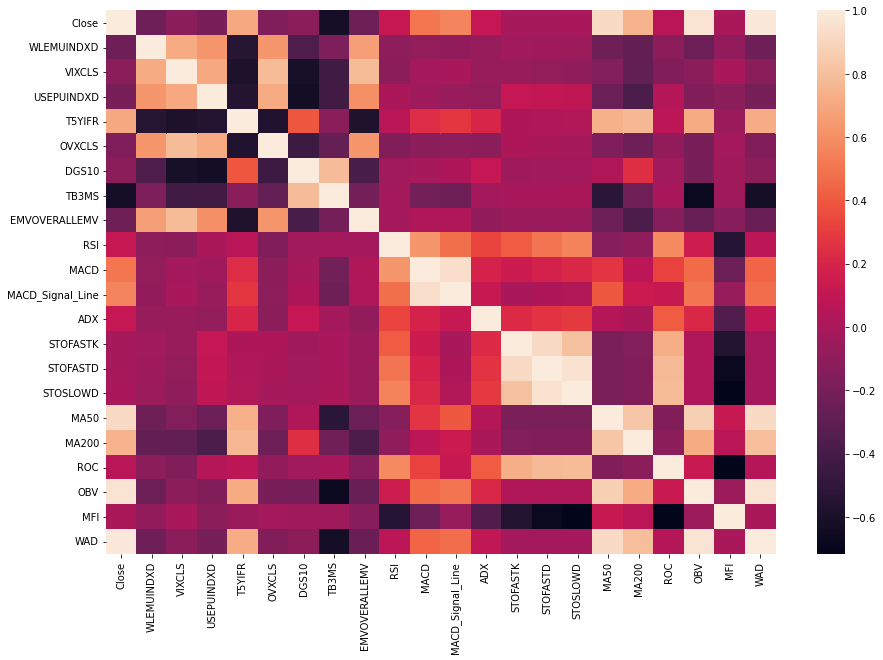

In [192]:
fig, ax = plt.subplots(figsize=(15,10))

corrMatrix = btc_df_merged.corr()
sn.heatmap(corrMatrix)
plt.show()

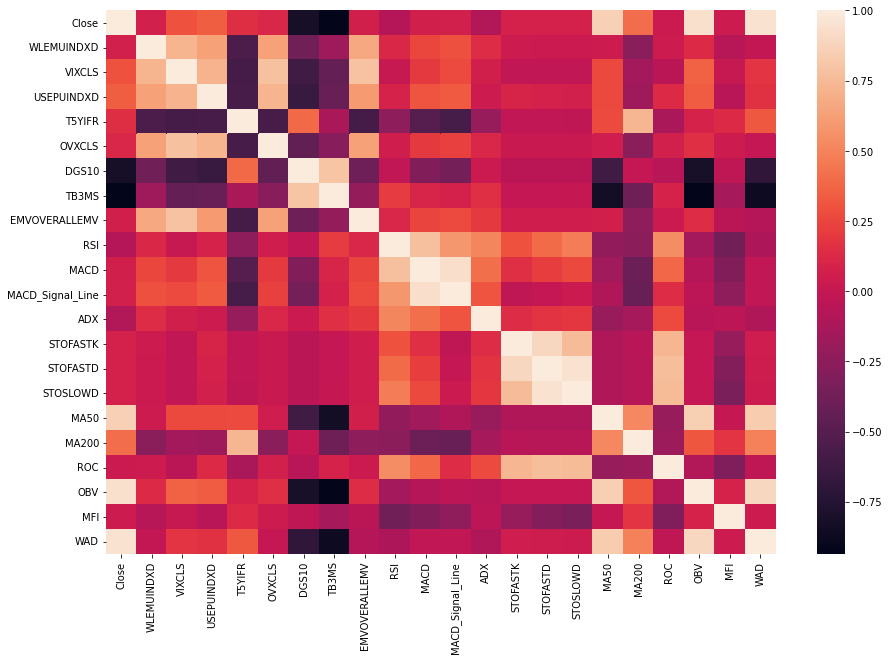

In [193]:
fig, ax = plt.subplots(figsize=(15,10))

corrMatrix = gld_df_merged.corr()
sn.heatmap(corrMatrix)
plt.show()

In [194]:
X_btc_train.info()
X_btc_train.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 548 entries, 340 to 579
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WLEMUINDXD        548 non-null    float64
 1   VIXCLS            548 non-null    float64
 2   USEPUINDXD        548 non-null    float64
 3   T5YIFR            548 non-null    float64
 4   OVXCLS            548 non-null    float64
 5   DGS10             548 non-null    float64
 6   TB3MS             548 non-null    float64
 7   EMVOVERALLEMV     548 non-null    float64
 8   RSI               548 non-null    float64
 9   MACD              548 non-null    float64
 10  MACD_Signal_Line  548 non-null    float64
 11  ADX               548 non-null    float64
 12  STOFASTK          548 non-null    float64
 13  STOFASTD          548 non-null    float64
 14  STOSLOWD          548 non-null    float64
 15  MA50              548 non-null    float64
 16  MA200             548 non-null    float64


,count,mean,std,min,25%,50%,75%,max
WLEMUINDXD,548.0,1.028300e+02,1.079641e+02,7.470000e+00,3.499000e+01,7.051000e+01,1.317175e+02,9.395800e+02
VIXCLS,548.0,2.124913e+01,9.493981e+00,1.175000e+01,1.556750e+01,1.863500e+01,2.403000e+01,8.269000e+01
USEPUINDXD,548.0,1.743432e+02,1.276487e+02,1.985000e+01,8.830500e+01,1.291500e+02,2.235725e+02,8.076600e+02
T5YIFR,548.0,1.908581e+00,2.541709e-01,1.100000e+00,1.750000e+00,1.906476e+00,2.110000e+00,2.410000e+00
OVXCLS,548.0,4.598920e+01,3.139464e+01,2.400000e+01,3.366750e+01,3.759000e+01,4.396000e+01,3.251500e+02
DGS10,548.0,1.505594e+00,5.973759e-01,5.500000e-01,9.600000e-01,1.520000e+00,1.800000e+00,2.760000e+00
TB3MS,548.0,8.405839e-01,9.585524e-01,2.000000e-02,5.000000e-02,1.300000e-01,1.890000e+00,2.400000e+00
EMVOVERALLEMV,548.0,2.454059e+01,9.365967e+00,1.392480e+01,1.880680e+01,2.144975e+01,2.948034e+01,6.336377e+01
RSI,548.0,6.236732e-01,3.349673e-01,0.000000e+00,3.767052e-01,7.150742e-01,9.373291e-01,9.993248e-01
MACD,548.0,8.947534e+02,2.276534e+03,-4.329738e+03,-6.315649e+01,4.093425e+02,1.426209e+03,7.141684e+03


In [195]:
X_gld_train.info()
X_gld_train.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 90 to 20
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WLEMUINDXD        529 non-null    float64
 1   VIXCLS            529 non-null    float64
 2   USEPUINDXD        529 non-null    float64
 3   T5YIFR            529 non-null    float64
 4   OVXCLS            529 non-null    float64
 5   DGS10             529 non-null    float64
 6   TB3MS             529 non-null    float64
 7   EMVOVERALLEMV     529 non-null    float64
 8   RSI               529 non-null    float64
 9   MACD              529 non-null    float64
 10  MACD_Signal_Line  529 non-null    float64
 11  ADX               529 non-null    float64
 12  STOFASTK          529 non-null    float64
 13  STOFASTD          529 non-null    float64
 14  STOSLOWD          529 non-null    float64
 15  MA50              529 non-null    float64
 16  MA200             529 non-null    float64
 1

,count,mean,std,min,25%,50%,75%,max
WLEMUINDXD,529.0,103.894650,108.851060,6.300000,35.940000,6.958000e+01,1.346200e+02,9.395800e+02
VIXCLS,529.0,21.330033,8.916390,11.540000,15.700000,1.877000e+01,2.446000e+01,7.200000e+01
USEPUINDXD,529.0,175.160491,128.740994,22.250000,87.560000,1.305100e+02,2.240100e+02,8.076600e+02
T5YIFR,529.0,1.907775,0.256256,0.860000,1.740000,1.920000e+00,2.100000e+00,2.410000e+00
OVXCLS,529.0,45.746850,29.579200,24.000000,33.540000,3.740000e+01,4.356000e+01,2.368000e+02
DGS10,529.0,1.484717,0.608513,0.520000,0.920000,1.520000e+00,1.800000e+00,2.790000e+00
TB3MS,529.0,0.816144,0.951285,0.020000,0.050000,1.300000e-01,1.650000e+00,2.400000e+00
EMVOVERALLEMV,529.0,24.521018,9.087330,13.924800,19.526620,2.144975e+01,2.948034e+01,6.336377e+01
RSI,529.0,0.585633,0.300624,0.027714,0.324252,5.854303e-01,8.925412e-01,1.000000e+00
MACD,529.0,9.958515,21.134767,-38.520843,-4.290652,5.686815e+00,2.675588e+01,7.336741e+01


In [196]:
Y_btc_train

340     6880.323242
488    16317.808594
411    11100.467773
375     9795.700195
271     8807.010742
           ...     
183    10360.546875
214     9256.148438
184    10276.793945
211     7514.671875
579    54529.144531
Name: Close, Length: 548, dtype: float64

In [197]:
RFR_btc_model = RandomForestRegressor(n_estimators=100)
RFR_btc_model.fit(X_btc_train, Y_btc_train)

RandomForestRegressor()

In [198]:
RFR_gld_model = RandomForestRegressor(n_estimators=100)
RFR_gld_model.fit(X_gld_train, Y_gld_train)

RandomForestRegressor()

In [85]:
RFR_btc_model.predict(X_btc_test[:10])

array([ 6467.25802734,  9015.48529785, 28251.63787109,  7462.24506348,
        7184.12208008, 32141.22755859, 46984.46375   ,  6603.63221191,
       50539.46628906,  9767.08588867])

In [199]:
RFR_gld_model.predict(X_gld_test[:10])

array([1482.50199463, 1311.58401367, 1729.78400024, 1761.21399414,
       1883.50698975, 1717.60902466, 1281.92800415, 1904.19199829,
       1891.18499878, 1409.7089978 ])

In [86]:
Y_btc_test[:10]

210      6487.160156
86       9119.009766
781     27362.437500
496      7218.371094
521      7193.599121
923     31780.730469
826     48378.988281
202      6585.529785
1027    50504.796875
668      9581.072266
Name: Close, dtype: float64

In [200]:
Y_gld_test[:10]

213    1480.800049
27     1307.000000
560    1732.900024
695    1759.599976
393    1897.300049
356    1725.199951
94     1274.500000
452    1900.800049
463    1890.400024
123    1409.699951
Name: Close, dtype: float64

In [202]:
RFR_btc_model.score(X_btc_test, Y_btc_test)

0.9979333388482381

In [201]:
RFR_gld_model.score(X_gld_test, Y_gld_test)

0.9964033447078046

## Logisitic Regression


In [206]:
LR_btc_model = LogisticRegression()
LR_btc_model.fit(X_btc_train, Y_btc_train)

ValueError: ignored

In [204]:
Y_btc_predict = LR_btc_model.predict(X_btc_test)
print("Accuracy Score is {}".format(accuracy_score(Y_btc_test, Y_btc_predict)))

NameError: ignored

In [213]:
X_btc_test.head()

,WLEMUINDXD,VIXCLS,USEPUINDXD,T5YIFR,OVXCLS,DGS10,TB3MS,EMVOVERALLEMV,RSI,MACD,...,ADX,STOFASTK,STOFASTD,STOSLOWD,MA50,MA200,ROC,OBV,MFI,WAD
152,59.15,17.87,150.20,1.93,36.43,1.90,1.95,30.88200,0.428254,669.565069,...,16.746343,65.437836,37.992725,23.688940,9897.448379,20048.653434,-0.119865,4.317551e+11,0.561192,7701.169922
468,35.89,27.41,200.48,1.89,44.06,0.76,0.10,30.43484,0.639728,173.478721,...,18.684359,70.638860,77.936283,81.033157,11091.630957,9383.295679,0.057189,6.491153e+11,0.566837,10322.919434
363,150.51,28.16,418.96,1.44,84.98,0.66,0.13,35.74074,0.901222,467.773674,...,27.683953,49.817800,54.740259,67.133461,7642.571436,8422.288728,0.030285,4.172412e+11,0.399310,7203.139160
106,18.25,17.90,55.62,1.91,36.43,2.25,2.35,19.52662,0.999241,977.412321,...,54.264193,90.978931,93.773473,91.787846,5871.781479,20048.653434,0.402453,3.422768e+11,0.312483,5258.039551
359,268.63,29.30,511.62,1.50,76.14,0.73,0.13,35.74074,0.890705,426.044552,...,29.358200,87.779042,82.308214,77.455556,7419.357363,8442.874031,0.245869,4.240486e+11,0.273421,7595.079590


## Support Vector Regression

In [207]:
from sklearn.svm import SVR
# Create and train the Support Vector Machine 
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.00001)#Create the model
svr_rbf.fit(X_btc_train, Y_btc_train) #Train the model

SVR(C=1000.0, gamma=1e-05)

In [208]:
svr_rbf_confidence = svr_rbf.score(X_btc_test, Y_btc_test)
print("svr_rbf accuracy: ", svr_rbf_confidence)

svr_rbf accuracy:  -0.3941786193715042


In [209]:
svm_prediction = svr_rbf.predict(X_btc_test)


In [210]:
print(svm_prediction)

[10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12732422 10463.12732422 10463.12732422
 10463.12732422 10463.12

In [212]:
print(Y_btc_test)

152    10399.668945
468    11322.123047
363     9182.577148
106     8659.487305
359     9726.575195
           ...     
386     9313.610352
539    32366.392578
43      3859.583740
243     7546.996582
764    50582.625000
Name: Close, Length: 236, dtype: float64
